In [2]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
import warnings 
warnings.filterwarnings('ignore')

import sklearn.metrics

import numpy as np


In [3]:
test_data = pd.read_json('datasets/rcqa/test.jsonl', orient='records', lines=True)
#test_data = pd.read_json('datasets/rcqa/val.jsonl', orient='records', lines=True)
test_data.head()

,qid,competition,timestamp,format,question,answer,title,text,score,did
0,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,ランウェイ,ランウェイ (runway) あるいはキャットウォーク (catwalk) とは、ファッショ...,4,1
1,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,Prism Stone,2012年3月30日、パシフィコ横浜で行われたタカラトミー主催のイベント「プリティーガールズ...,1,2
2,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,仙台コレクション,屋内で開催される同種のリアル・クローズのファッションショーで見られる出展ブランドの特設直販ブ...,0,3
3,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,ファッションショー,ファッションショーでは、予め選ばれたモデルが売り手側が用意した服を着て、観客席に挟まれた細長...,4,4
4,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,マンチカン,体長より少しばかり短い、動作豊かな尻尾を持つ。片足をもう一方の足と同じ直線上に置きつつ、尻尾...,0,5


# bert-classificationの結果整理

- test_dataでなくval_dataのgold, pred を出していた。n_epochを小さくして、testまで回す
- gold, predの順序と val_data の順序が違う？ラベルが合わない。dataloaderのn_workers > 1 のせい?

In [4]:
# 途中epochで中断した結果 accuracy, precision, recall, f1 それぞれ 0.40かそれを若干切る程度
gold = pd.read_csv('gold_labels', header=None).iloc[:, 0].values.astype('int')
pred = pd.read_csv('pred_labels', header=None).iloc[:, 0].values.astype('int')

# accuracy
(gold == pred).sum() / len(gold)

0.476010101010101

In [5]:
# 途中epochで中断した結果 accuracy, precision, recall, f1 それぞれ 0.40かそれを若干切る程度
gold = pd.read_csv('outputs/cl-tohoku__bert-base-japanese-v2/2023-02-16/09-36-14/gold_labels', header=None).iloc[:, 0].values.astype('int')
pred = pd.read_csv('outputs/cl-tohoku__bert-base-japanese-v2/2023-02-16/09-36-14/pred_labels', header=None).iloc[:, 0].values.astype('int')

# accuracy
(gold == pred).sum() / len(gold)

0.4662698412698413

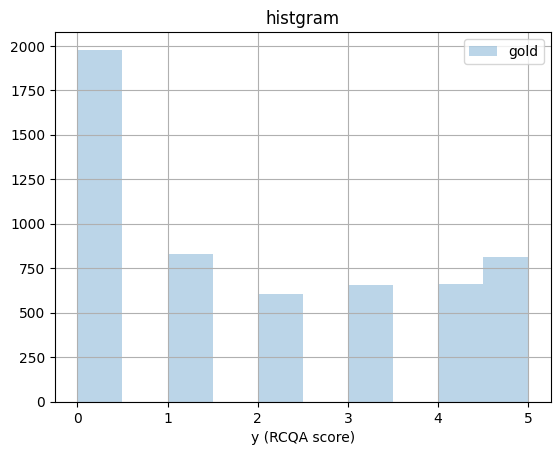

In [6]:
plt.hist(gold, alpha=0.3, label='gold')
plt.title('histgram')
plt.xlabel('y (RCQA score)')
plt.legend()
plt.grid()

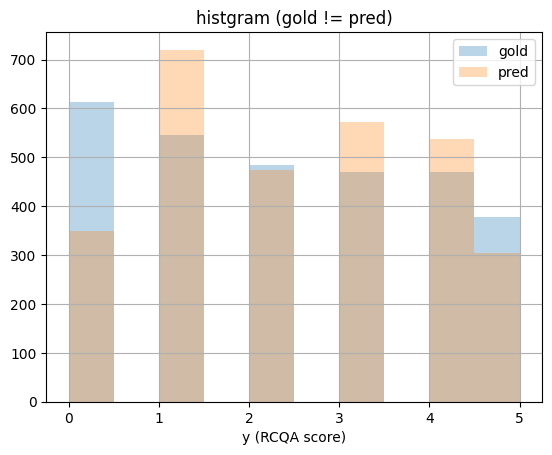

In [7]:
plt.hist(gold[gold != pred], alpha=0.3, label='gold')
plt.hist(pred[gold != pred], alpha=0.3, label='pred')
plt.title('histgram (gold != pred)')
plt.xlabel('y (RCQA score)')
plt.legend()
plt.grid()

↑ 両端でなく

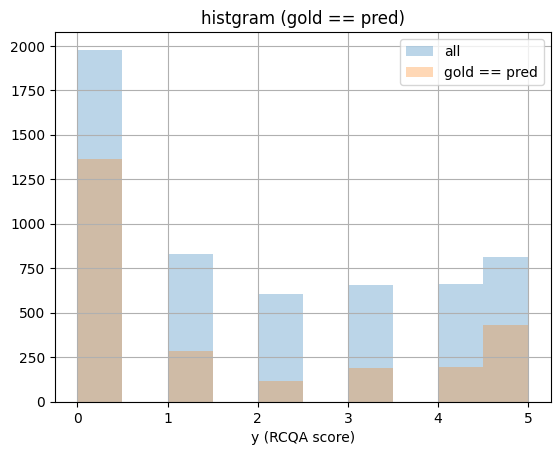

In [8]:
plt.hist(gold, alpha=0.3, label='all')
plt.hist(gold[gold == pred], alpha=0.3, label='gold == pred')
plt.title('histgram (gold == pred)')
plt.xlabel('y (RCQA score)')
plt.legend()
plt.grid()

In [9]:
sklearn.metrics.accuracy_score(gold, pred)

0.4662698412698413

In [10]:
# マイクロ平均での評価指標
sklearn.metrics.precision_score(gold, pred, average='micro'),  sklearn.metrics.recall_score(gold, pred, average='micro'), sklearn.metrics.f1_score(gold, pred, average='micro')

(0.4662698412698413, 0.4662698412698413, 0.46626984126984133)

In [11]:
# マクロ平均での評価指標
sklearn.metrics.precision_score(gold, pred, average='macro'),  sklearn.metrics.recall_score(gold, pred, average='macro'), sklearn.metrics.f1_score(gold, pred, average='macro')

(0.3967221111636447, 0.3906848057420147, 0.3920458469868718)

In [12]:
# 混同行列
sklearn.metrics.confusion_matrix( gold, pred)
# 行 gold, 列 pred

array([[1365,  409,  119,   70,   13,    2],
       [ 261,  285,  123,  110,   42,    9],
       [  57,  174,  119,  139,   87,   27],
       [  23,   83,  114,  188,  175,   75],
       [   7,   42,   80,  148,  195,  192],
       [   2,   12,   38,  106,  220,  433]])

大きく予測を間違うものは何か特徴があるだろう。(gold =5, pred=0 や gold=0, pred=5のケース)

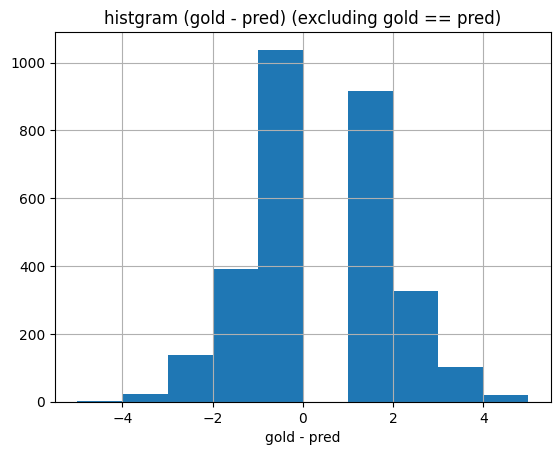

In [13]:
plt.hist(gold[gold != pred] - pred[gold != pred])
plt.xlabel('gold - pred')
plt.title('histgram (gold - pred) (excluding gold == pred)')
plt.grid()

↑予測誤差はきれいなカーブをなしているように見える。予測誤差が小さな場合が多いので、二値判定であれば問題ない可能性がある。

In [14]:
# 予測ラベル差が +/-0
(abs(gold - pred) < 1).sum(), (abs(gold - pred) < 1).sum() / len(gold)

(2585, 0.4662698412698413)

In [15]:
# 予測ラベル差が +/-1以内
(abs(gold - pred) < 2).sum(), (abs(gold - pred) < 2).sum() / len(gold)

(4540, 0.8189033189033189)

In [16]:
# 予測ラベル差が +/-2以内
(abs(gold - pred) < 3).sum(), (abs(gold - pred) < 3).sum() / len(gold)

(5257, 0.9482323232323232)

In [17]:
# https://alaginrc.nict.go.jp/nict-bert/Experiments_on_RCQA.html
# スコア2以上か否かの二値分類に
gold_b, pred_b  =  gold > 1, pred > 1

In [18]:
sklearn.metrics.accuracy_score(gold_b, pred_b)

0.8398268398268398

In [19]:
# マイクロ平均での評価指標
sklearn.metrics.precision_score(gold_b, pred_b, average='micro'),  sklearn.metrics.recall_score(gold_b, pred_b, average='micro'), sklearn.metrics.f1_score(gold_b, pred_b, average='micro')

(0.8398268398268398, 0.8398268398268398, 0.8398268398268398)

In [20]:
# マクロ平均での評価指標
sklearn.metrics.precision_score(gold_b, pred_b, average='macro'),  sklearn.metrics.recall_score(gold_b, pred_b, average='macro'), sklearn.metrics.f1_score(gold_b, pred_b, average='macro')

(0.8400683219463423, 0.8400059979007347, 0.8398255057314497)

In [21]:
# 混同行列
sklearn.metrics.confusion_matrix(gold_b, pred_b)
# 行 gold, 列 pred

array([[2320,  488],
       [ 400, 2336]])

In [22]:
test_data['pred'] = pred
test_data['gold'] = gold

In [36]:
index = np.random.choice(test_data[(abs(gold - pred) == 0)].index, size=5)
test_data.iloc[index]

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
115,11357,abc_08,2010-03-21,早押し,歌手ナット・キング・コールの代表曲のタイトルにもなっている、ロサンゼルスとシカゴを結んでいた...,ルート66,スプリングフィールド (ミズーリ州),1926年、国道システムが整備され、スプリングフィールドには2本の重要な国道が創設された。1...,4,4,4,4
2635,11935,abc_08,2010-03-21,早押し,1階では芥川賞、2階では直木賞の選考会が開かれる、東京都の築地にある料亭の名前は何でしょう?,新喜楽,直木三十五賞,2016年現在の選考委員は、浅田次郎、伊集院静、北方謙三、桐野夏生、高村薫、林真理子、東野圭...,5,1,5,5
299,11401,abc_08,2010-03-21,早押し,その中に「ローマは三度世界を統一した」というフレーズが登場する、ドイツの法学者イェーリングの...,ローマ法の精神,ルドルフ・フォン・イェーリング,1836年ハイデルベルク大学に入学し、その後ゲッティンゲン、ミュンヘンでも大学生活を送り、1...,1,3,1,1
3495,12139,abc_08,2010-03-21,早押し,「砂」を意味するラテン語を語源とする、周りを階段状の観客席で囲まれた競技場やコンサート会場な...,アリーナ,ホース・ガーズ・パレード,2012年には、ロンドン五輪のビーチバレー競技会場として使用された。アリーナと観覧席は、6月...,0,2,0,0
2853,11989,abc_08,2010-03-21,早押し,マラソン競技で、一定の距離ごとに計られる所要時間のことを何というでしょう?,スプリットタイム,ブリギット・マクマホン,マクマホーンはシドニーオリンピックでオリンピック初出場を果たした。そして現在も女子のトライア...,0,3,0,0


In [98]:
# 一致しているもののサンプル
test_data[(abs(gold - pred) == 0)].head()

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
2,11333,abc_08,2010-03-21,早押し,ファッションショーにおいてモデルが歩く、客席に突き出したステージのことを何というでしょう?,キャットウォーク,仙台コレクション,屋内で開催される同種のリアル・クローズのファッションショーで見られる出展ブランドの特設直販ブ...,0,3,0,0
5,11334,abc_08,2010-03-21,早押し,くちばしが左右互い違いになっていることから、物事が食い違っていることのたとえにも用いられるア...,イスカ,イスカ,イスカのくちばしは左右互い違いになっており、このくちばしを使って、マツやモミなどの針葉樹の種...,5,1,5,5
6,11334,abc_08,2010-03-21,早押し,くちばしが左右互い違いになっていることから、物事が食い違っていることのたとえにも用いられるア...,イスカ,イスカ,"イスカ(交喙、鶍、学名""Loxia curvirostra"")は、スズメ目アトリ科に分類され...",0,2,0,0
7,11334,abc_08,2010-03-21,早押し,くちばしが左右互い違いになっていることから、物事が食い違っていることのたとえにも用いられるア...,イスカ,ナキイスカ,日本では数少ない冬鳥として、本州中部以北に少数が渡来する。イスカの群れに混じっていることが多い。,0,3,0,0
9,11335,abc_08,2010-03-21,早押し,ダーツの矢の、先端部分を「ティップ」といいますが、後ろの羽根の部分を何というでしょう?,フライト,ダーツ,シャフトとはダーツ後部のフライトが取り付けられている部分であり、矢で言うところの箆(の)の後...,2,1,2,2


In [42]:
# 予測が極端に異なるもの goldが高いものは予測を的中させたい
test_data[(abs(gold - pred) > 3)].head()

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
252,11390,abc_08,2010-03-21,早押し,室町時代に起こった応仁の乱で、東軍の大将は細川勝元ですが、西軍の大将は誰でしょう?,山名宗全,竹田城,応仁元年(1467年)、細川勝元と山名宗全の争いが一因で応仁の乱が起こると但馬は細川氏と山名...,4,3,0,4
394,11422,abc_08,2010-03-21,早押し,日本から見るカシオペア座や北斗七星などのように、一日中地平線に沈まない星のことを何というでしょう?,周極星,ケンタウルス座アルファ星,南緯29度以南になると、ケンタウルス座α星は周極星になり、地平線の下に沈む事はない。ケンタウ...,5,3,1,5
418,11428,abc_08,2010-03-21,早押し,近代建築の四巨匠に数えられるドイツの建築家で、造形芸術学校バウハウスを創立し、その初代校長を...,ヴァルター・グロピウス,マルティン・グロピウス,"マルティン・グロピウス (Martin Gropius, 1824年8月11日ベルリン - ...",1,1,5,1
477,11440,abc_08,2010-03-21,早押し,白石一文の直木賞受賞作は『ほかならぬ人へ』ですが、その父である白石一郎の直木賞受賞作は何でしょう?,海狼伝,白石一郎,直木賞には、「孤島の騎士」(1970)、「火炎城」(1974)、「一炊の夢」「幻島記」(19...,4,1,0,4
478,11440,abc_08,2010-03-21,早押し,白石一文の直木賞受賞作は『ほかならぬ人へ』ですが、その父である白石一郎の直木賞受賞作は何でしょう?,海狼伝,白石一郎,代表作は直木賞を受賞した『海狼伝』で、ほかにも「海」を舞台にした(または「海」を冠した)作品...,5,2,0,5


In [44]:
# 予測が極端に異なるもの goldが高いものは予測を的中させたい
test_data[(abs(gold - pred) > 3)].sort_values(by='score', ascending=True).head()

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
3337,12104,abc_08,2010-03-21,早押し,別名を「シロバナムシヨケギク」という、ピレトリンという成分を含むため殺虫剤の原料に使用される...,除虫菊,ピレスロイド,"ピレスロイド (pyrethroid) とは、除虫菊 (""Tanacetum cinerar...",0,4,4,0
5232,12523,EQIDEN_2010,2010-03-21,早押し,毎年秋に中山競馬場で開催される重賞レースにその名が冠せられている、日本競馬史上初のクラシック...,セントライト,シンボリルドルフ,秋緒戦、故障した右肩も回復し、すっかりリフレッシュしたシンボリルドルフはセントライト記念(中...,0,4,4,0
4599,12385,EQIDEN_2010,2010-03-21,早押し,アルキメデスがその原理を発見したとされる、「ある物質を流体に沈めた時、重力とは逆の方向に作用...,浮力,Eureka,なお、このとき発見したのは、今日アルキメデスの原理として知られているものではない。アルキメデ...,0,2,4,0
4379,12335,EQIDEN_2010,2010-03-21,早押し,腐食しにくく摩耗しづらいことから高級万年筆のペン先に用いられることもある、原子番号77、元素...,イリジウム,貴金属,貴金属(ききんぞく、precious metal)は、化学としては金 (Au)、銀 (Ag)...,0,4,4,0
3909,12235,EQIDEN_2010,2010-03-21,早押し,ジェームズ・バリーの童話『ピーターパン』で、フック船長が嫌いな動物は何でしょう?,ワニ,ピーター・パン (1953年の映画),原作はジェームス・マシュー・バリーの戯曲『大人になりたくないピーターパン』。それをウォルト・...,0,1,4,0


In [45]:
# 予測が極端に異なるもの goldが高いものは予測を的中させたい
test_data[(abs(gold - pred) > 3)].sort_values(by='score', ascending=False).head()

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
4591,12383,EQIDEN_2010,2010-03-21,早押し,日本の国旗の赤い丸は太陽を意味していますが、パラオの国旗の黄色い丸はどんな天体を意味している...,月,パラオの国旗,2010年10月に元埼玉県立大学教授で国旗に詳しい吹浦忠正(現ユーラシア21研究所理事長)は...,5,4,1,5
5388,12557,EQIDEN_2010,2010-03-21,早押し,1953年のミス・ユニバースで3位に入賞し、「八頭身美人」という流行語を生んだ日本のモデルは...,伊東絹子,ミス・ユニバース・ジャパン,日本代表は1950年代、合計3人が上位入賞(総合5位以内)するという結果を残し、1953年(...,5,1,1,5
394,11422,abc_08,2010-03-21,早押し,日本から見るカシオペア座や北斗七星などのように、一日中地平線に沈まない星のことを何というでしょう?,周極星,ケンタウルス座アルファ星,南緯29度以南になると、ケンタウルス座α星は周極星になり、地平線の下に沈む事はない。ケンタウ...,5,3,1,5
1824,11745,abc_08,2010-03-21,早押し,アインシュタインが提唱した「一般相対性理論」と「特殊相対性理論」のうち、先に発表されたのはど...,特殊相対性理論,一般相対性理論,"一般相対性理論(いっぱんそうたいせいりろん、, )は、アルベルト・アインシュタインが1905...",5,2,1,5
5237,12524,EQIDEN_2010,2010-03-21,早押し,インカ帝国を滅ぼしたのはフランシスコ・ピサロですが、アステカ帝国を滅ぼしたのは誰でしょう?,エルナン・コルテス,近世における世界の一体化,当時の南北アメリカには、先史時代にアジアからベーリング海峡を渡った人々が独自の文明を発達させ...,5,4,1,5


In [40]:
# goldとpredが極端に異なる question-answer-passage の一例について、他のpassageを含めた一覧
index = np.random.choice(test_data[(abs(gold - pred) > 3) & (gold == 5)].index, size=5)
test_data.iloc[index]

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
394,11422,abc_08,2010-03-21,早押し,日本から見るカシオペア座や北斗七星などのように、一日中地平線に沈まない星のことを何というでしょう?,周極星,ケンタウルス座アルファ星,南緯29度以南になると、ケンタウルス座α星は周極星になり、地平線の下に沈む事はない。ケンタウ...,5,3,1,5
1637,11705,abc_08,2010-03-21,早押し,モナコ公国と極めてよく似たデザインの国旗をもつ、東南アジアの国はどこでしょう?,インドネシア,モナコ,国旗のデザインが国連基準の2:3の縦横比になるとインドネシアと同様になるため、両国の間で調整...,5,4,1,5
5388,12557,EQIDEN_2010,2010-03-21,早押し,1953年のミス・ユニバースで3位に入賞し、「八頭身美人」という流行語を生んだ日本のモデルは...,伊東絹子,ミス・ユニバース・ジャパン,日本代表は1950年代、合計3人が上位入賞(総合5位以内)するという結果を残し、1953年(...,5,1,1,5
394,11422,abc_08,2010-03-21,早押し,日本から見るカシオペア座や北斗七星などのように、一日中地平線に沈まない星のことを何というでしょう?,周極星,ケンタウルス座アルファ星,南緯29度以南になると、ケンタウルス座α星は周極星になり、地平線の下に沈む事はない。ケンタウ...,5,3,1,5
5237,12524,EQIDEN_2010,2010-03-21,早押し,インカ帝国を滅ぼしたのはフランシスコ・ピサロですが、アステカ帝国を滅ぼしたのは誰でしょう?,エルナン・コルテス,近世における世界の一体化,当時の南北アメリカには、先史時代にアジアからベーリング海峡を渡った人々が独自の文明を発達させ...,5,4,1,5


In [41]:
# goldとpredが極端に異なる question-answer-passage の一例について、他のpassageを含めた一覧
index = np.random.choice(test_data[(abs(gold - pred) > 3) & (gold == 0)].index, size=5)
test_data.iloc[index]

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
1236,11615,abc_08,2010-03-21,早押し,現在はジョン・ラルストン・サウルが会長を務めている、ロンドンに本部を置く、文学に関する国際的...,国際ペンクラブ,国際ペンクラブ,国際ペンクラブ(こくさいペンクラブ、PEN International)は、文学を通じて諸国...,0,4,4,0
3336,12104,abc_08,2010-03-21,早押し,別名を「シロバナムシヨケギク」という、ピレトリンという成分を含むため殺虫剤の原料に使用される...,除虫菊,殺虫剤,その後、カラバル豆の有毒なアルカロイド成分であるフィゾスチグミンを参考にして有機リン系と同様...,0,3,4,0
1534,11683,abc_08,2010-03-21,早押し,現在、囲碁の名人戦と将棋の名人戦の両方の主催に携わっている新聞社はどこでしょう?,朝日新聞社,名人戦 (将棋),名人戦(めいじんせん)は、、毎日新聞社と朝日新聞社共催の将棋の棋戦で、全8タイトル戦(竜王戦...,0,2,4,0
5537,12590,EQIDEN_2010,2010-03-21,早押し,ドミニカ国の首都はロゾーですが、ドミニカ共和国の首都はどこでしょう?,サント・ドミンゴ,サントドミンゴ,サント・ドミンゴは、1844年2月27日に、ドミニカ人が国民的英雄に率いられ、ハイチの支配か...,0,4,5,0
5232,12523,EQIDEN_2010,2010-03-21,早押し,毎年秋に中山競馬場で開催される重賞レースにその名が冠せられている、日本競馬史上初のクラシック...,セントライト,シンボリルドルフ,秋緒戦、故障した右肩も回復し、すっかりリフレッシュしたシンボリルドルフはセントライト記念(中...,0,4,4,0


In [88]:
# goldとpredが極端に異なる question-answer-passage を列挙
test_data[(abs(gold - pred) > 3)].qid.value_counts()

11741    2
11440    2
12104    2
12385    2
12459    1
12230    1
12235    1
12285    1
12335    1
12351    1
12383    1
11390    1
12174    1
12463    1
12480    1
12497    1
12523    1
12524    1
12547    1
12557    1
12571    1
12179    1
12135    1
12155    1
11422    1
11428    1
11468    1
11493    1
11615    1
11683    1
11705    1
11724    1
11735    1
11745    1
11812    1
11850    1
11992    1
11997    1
12028    1
12050    1
12590    1
Name: qid, dtype: int64

1183

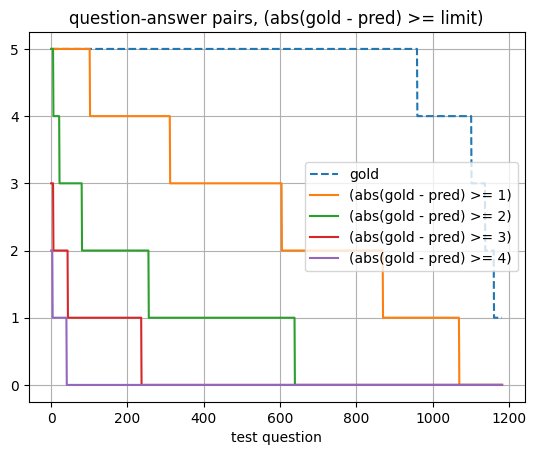

In [74]:
# goldとpredが極端に異なる question-answer-passage を列挙して頻度分布
#plt.plot(test_data[(abs(gold - pred) > 3)].qid.value_counts().values)
plt.plot(range(len(test_data.qid.value_counts())), test_data.qid.value_counts(), linestyle='dashed', label='gold')

for v_limit in range(1,5):
    plt.plot(np.concatenate([test_data[(abs(gold - pred) > (v_limit - 1))].qid.value_counts().values, 
                         [0] * (len(test_data.qid.unique()) - len(test_data[(abs(gold - pred) > (v_limit - 1))].qid.value_counts().values))]), label=f'(abs(gold - pred) >= {v_limit})')


plt.grid()
plt.title(f'question-answer pairs, (abs(gold - pred) >= limit)')
plt.xlabel('test question')
plt.legend()
len(test_data.qid.unique())

<AxesSubplot: >

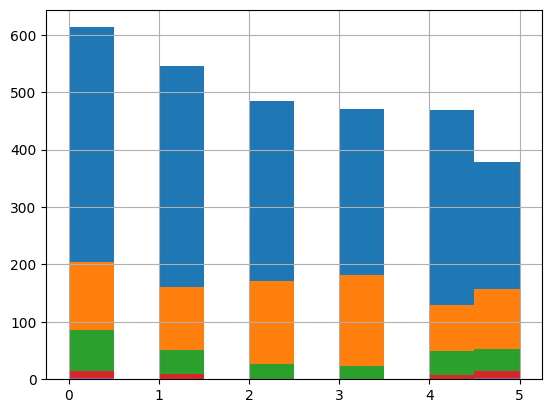

In [93]:
v_limit = 1
test_data[(abs(gold - pred) > (v_limit - 1))].score.hist()
v_limit = 2
test_data[(abs(gold - pred) > (v_limit - 1))].score.hist()
v_limit = 3
test_data[(abs(gold - pred) > (v_limit - 1))].score.hist()
v_limit = 4
test_data[(abs(gold - pred) > (v_limit - 1))].score.hist()
v_limit = 5
test_data[(abs(gold - pred) > (v_limit - 1))].score.hist()

<AxesSubplot: >

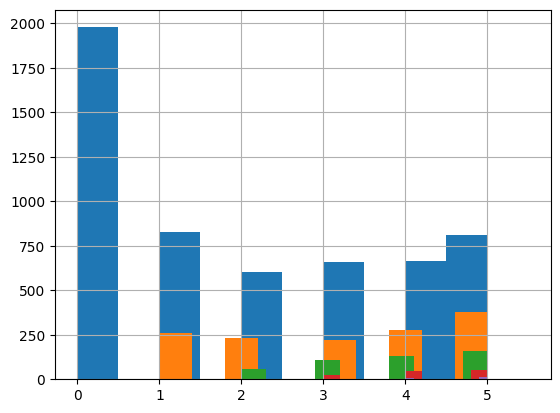

In [94]:
bins=10
test_data.score.hist(bins=bins)
v_limit = 1
test_data[((gold - pred) > (v_limit - 1))].score.hist(bins=bins)
v_limit = 2
test_data[((gold - pred) > (v_limit - 1))].score.hist(bins=bins)
v_limit = 3
test_data[((gold - pred) > (v_limit - 1))].score.hist(bins=bins)
v_limit = 4
test_data[((gold - pred) > (v_limit - 1))].score.hist(bins=bins)
v_limit = 5
test_data[((gold - pred) > (v_limit - 1))].score.hist(bins=bins)

↑ 1なのに0と言ってしまうなどの例

<AxesSubplot: >

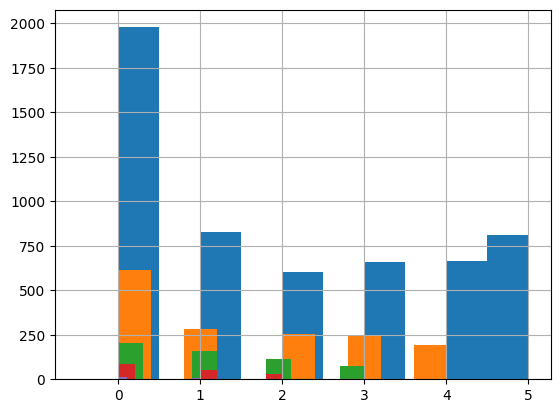

In [95]:
bins=10
test_data.score.hist(bins=bins)
v_limit = 1
test_data[((pred - gold) > (v_limit - 1))].score.hist(bins=bins)
v_limit = 2
test_data[((pred - gold) > (v_limit - 1))].score.hist(bins=bins)
v_limit = 3
test_data[((pred - gold) > (v_limit - 1))].score.hist(bins=bins)
v_limit = 4
test_data[((pred - gold) > (v_limit - 1))].score.hist(bins=bins)
v_limit = 5
test_data[((pred - gold) > (v_limit - 1))].score.hist(bins=bins)

↑ 0なのに1と言ってしまうなどの例

予測を1違えているものが相当ある。どの正解ラベルで間違えやすいか? 両端か？中間か？

In [75]:
# goldとpredが極端に異なる question-answer-passage の top-1
qid = test_data[(abs(gold - pred) > 3)].qid.value_counts().keys()[0]
test_data[test_data.qid == qid]

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
1807,11741,abc_08,2010-03-21,早押し,正式には『フランス・バニング・コック隊長とウィレム・ファン・ラウテンブルフ副隊長の市民隊』と...,夜警,レンブラント・ファン・レイン,「光の画家」「光の魔術師」(または「光と影の画家」「光と影の魔術師」)の異名を持ち、油彩だけ...,5,1,5,5
1808,11741,abc_08,2010-03-21,早押し,正式には『フランス・バニング・コック隊長とウィレム・ファン・ラウテンブルフ副隊長の市民隊』と...,夜警,夜警 (絵画),夜警(やけい、オランダ語:De Nachtwacht)は、オランダの17世紀の画家レンブラン...,4,2,5,4
1809,11741,abc_08,2010-03-21,早押し,正式には『フランス・バニング・コック隊長とウィレム・ファン・ラウテンブルフ副隊長の市民隊』と...,夜警,レンブラント・ファン・レイン,レンブラントの著名な作品として『フランス・バニング・コック隊長の市警団(夜警)』が挙げられる...,1,3,5,1
1810,11741,abc_08,2010-03-21,早押し,正式には『フランス・バニング・コック隊長とウィレム・ファン・ラウテンブルフ副隊長の市民隊』と...,夜警,夜警 (絵画),『夜警』はオランダ黄金時代の絶頂期であった1642年に完成した。この絵は題名となった市民隊(...,0,4,5,0
1811,11741,abc_08,2010-03-21,早押し,正式には『フランス・バニング・コック隊長とウィレム・ファン・ラウテンブルフ副隊長の市民隊』と...,夜警,レンブラント広場,画家レンブラント・ファン・レインの生誕400周年を記念して造られた公園で園内には彼の代表作の...,3,5,2,3


In [97]:
# goldとpredが極端に異なる question-answer-passage の top-2
qid = test_data[(abs(gold - pred) > 3)].qid.value_counts().keys()[1]
test_data[test_data.qid == qid]

,qid,competition,timestamp,format,question,answer,title,text,score,did,pred,gold
477,11440,abc_08,2010-03-21,早押し,白石一文の直木賞受賞作は『ほかならぬ人へ』ですが、その父である白石一郎の直木賞受賞作は何でしょう?,海狼伝,白石一郎,直木賞には、「孤島の騎士」(1970)、「火炎城」(1974)、「一炊の夢」「幻島記」(19...,4,1,0,4
478,11440,abc_08,2010-03-21,早押し,白石一文の直木賞受賞作は『ほかならぬ人へ』ですが、その父である白石一郎の直木賞受賞作は何でしょう?,海狼伝,白石一郎,代表作は直木賞を受賞した『海狼伝』で、ほかにも「海」を舞台にした(または「海」を冠した)作品...,5,2,0,5
